In [ ]:
!pip install transformers
!pip install -q datasets

In [97]:
from datasets import load_dataset
import torch
import numpy as np
import transformers
import pandas as pd
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# **Dataset Operations and Preprocessing**

Note: As we were developing this model the emotions dataset had a bug so we used Setfit/emotion insted. [Issue Link](https://github.com/huggingface/datasets/issues/5342)

In [ ]:
dataset = load_dataset("SetFit/emotion")

**Tokenization**

In [100]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [50]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [101]:
tokenized = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

# **Text Classification**

We fine-tune the distilBERT model for emotion analysis.

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # preferred gpu since it is faster

In [103]:
model = (AutoModelForSequenceClassification
         .from_pretrained("distilbert-base-uncased", num_labels=6)
         .to(device))

In [75]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

We start with 2 epochs, it can be increased further for better accuracy.

In [76]:
batch_size = 64
logging_steps = len(tokenized["train"]) // batch_size
model_name = "distilbert-base-uncased-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error")

In [77]:
trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized["train"],
                  eval_dataset=tokenized["validation"],
                  tokenizer=tokenizer)
trainer.train();

/content/distilbert-base-uncased-finetuned-emotion is already a clone of https://huggingface.co/sarpert/distilbert-base-uncased-finetuned-emotion. Make sure you pull the latest changes with `repo.git_pull()`.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.833400,0.332668,0.902500,0.900065


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.833400,0.332668,0.902500,0.900065
2,0.254100,0.224761,0.922500,0.922589


In [78]:
preds_output = trainer.predict(tokenized["validation"])

In [79]:
preds_output.metrics

{'test_loss': 0.22476106882095337,
 'test_accuracy': 0.9225,
 'test_f1': 0.9225894639278417,
 'test_runtime': 243.2885,
 'test_samples_per_second': 8.221,
 'test_steps_per_second': 0.132}

In [80]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [114]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Oranges", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Confusion matrix")
    plt.show()

In [92]:
y_valid = np.array(tokenized["validation"]["label"])

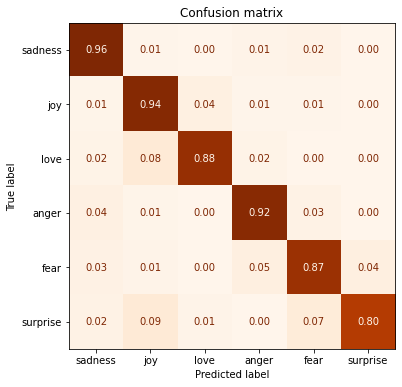

In [115]:
labels = ["sadness","joy", "love", "anger", "fear","surprise"]
plot_confusion_matrix(y_preds, y_valid, labels)

# Experimenting

Since fine-tuning distilBERT for our emotion dataset takes a long time even with low epoch count, we thought that reducing the size of the dataset could be a good way to make it faster. Of course this would effect the model badly and the bigger dataset will be more accurate but this is for quality of life to test our changes.

In [146]:
import random
from sklearn.model_selection import StratifiedShuffleSplit

# Extract the labels from the dataset
labels_ext = [example['label'] for example in dataset['train']]

# Create a stratified shuffle split object
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)

# Split the data into train and test sets
train_indices, test_indices = next(sss.split(dataset['train'], labels_ext))
train_indices = train_indices.tolist()
test_indices = test_indices.tolist()

# Create the stratified train and test sets
stratified_train_set = [dataset['train'][i] for i in train_indices]
stratified_test_set = [dataset['train'][i] for i in test_indices]

# Split the stratified train set into train and validation sets
train_set_size = len(stratified_train_set)

train_set, val_set = torch.utils.data.random_split(stratified_train_set, [int(0.8 * train_set_size), int(0.2 * train_set_size)])
test_set = dataset['test']

In [147]:
# Calculate the size of the original dataset
original_size = len(dataset['train']) + len(dataset['test'])

# Calculate the size of the stratified train and test sets
stratified_size = len(stratified_train_set) + len(stratified_test_set)

# Calculate the size of the train, validation, and test sets
final_size = len(train_set) + len(val_set) + len(test_set)

original_percentage = 100 * original_size / original_size
stratified_percentage = 100 * stratified_size / original_size
final_percentage = 100 * final_size / original_size

# Print the sizes of the datasets
print(f"Original size: {original_size}")
print(f"Stratified size: {stratified_size}")
print(f"Final size: {final_size}")

# Print the sizes of the datasets in terms of percentages
print(f"Original size: {original_percentage:.1f}%")
print(f"Stratified size: {stratified_percentage:.1f}%")
print(f"Final size: {final_percentage:.1f}%")

Original size: 18000
Stratified size: 16000
Final size: 11600
Original size: 100.0%
Stratified size: 88.9%
Final size: 64.4%
